In [88]:
# imports
from src.data.utils import gedi_utils
from src.data.pipelines.extract_gedi_data import SIERRAS_GEDI_ID_COLUMNS, SEKI_GEDI_ID_COLUMNS, SIERRAS_GEDI_ALL_COLUMNS, SEKI_GEDI_ALL_COLUMNS
from src.data.gedi import gedi_loader
from src.constants import GEDI_INTERMEDIATE_PATH, INTERMEDIATE_RESULTS
from fastai.tabular.all import load_pickle, save_pickle
from src.data.processing import severity_overlay as se
from src.data.processing import raster_overlays as ro
from src.data.adapters import calfire_perimeters as cp
from src.data.pipelines import run_overlays as overlays
from src.data.adapters import mtbs as mtbs_adapter
from src.data.pipelines import aggregate_analysis as aa
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", palette="Set2")
palette = sns.color_palette("Set2")

import pandas as pd

import importlib
importlib.reload(se)
importlib.reload(ro)
importlib.reload(gedi_utils)
importlib.reload(aa)

2024-01-22 23:18:56,248 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/severity_overlay.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-22 23:18:56,250 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/raster_overlays.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.pipelines.aggregate_analysis' from '/home/jk871/fire-regen/src/data/pipelines/aggregate_analysis.py'>

# Data Dependencies Notebook

This notebook tries to capture some of the relationships between GEDI variables - like rh98, pai - with other captured variables, like pre-fire NDVI, NDVI and terrain variables.

Given that GEDI vars are always our outcome variables that we want to understand the effects on, it's crucial to understand all the confounding variables that could affect them.

### Data PreProcessing

In [4]:
def get_output_path(file_name: str):
    return f"{aa.PIPELINES_PATH}/{file_name}"

In [41]:
df_in = load_pickle(get_output_path("severity_aggregated_info.pkl"))

In [12]:
unburned = df_in[df_in.fire_id.isna()]
burned = df_in[(df_in.fire_id.notna())]

874947

In [102]:
df_in.loc[unburned.index, "pre_fire_ndvi"] = unburned.ndvi

In [103]:
df = df_in[(df_in.YSF != 0) & (df_in.YSF < 36)]

In [104]:
df = gedi_utils.add_YSF_categories(df, 7)
df = gedi_utils.add_YSF_categories(df, 10)

In [108]:
df["ndvi_ratio"] = df["ndvi"] / df["pre_fire_ndvi"]

In [109]:
burned = df[df.YSF > 0]
unburned = df[df.YSF < 0]

## GEDI vars VS. pre-fire NDVI

These graphs capture the relationship between GEDI SFT subtitution, and pre-fire NDVI. In an ideal world, we want to control for everything but time that past since fire (YSF).

If we didn't have to do SFT, then pre-fire NDVI would be the same for all YSF buckets, and would only affect GEDI variable through time if pre-fire NDVI affected recovery rates themselves.

### SFT Plots

<AxesSubplot: xlabel='YSF', ylabel='pre_fire_ndvi'>

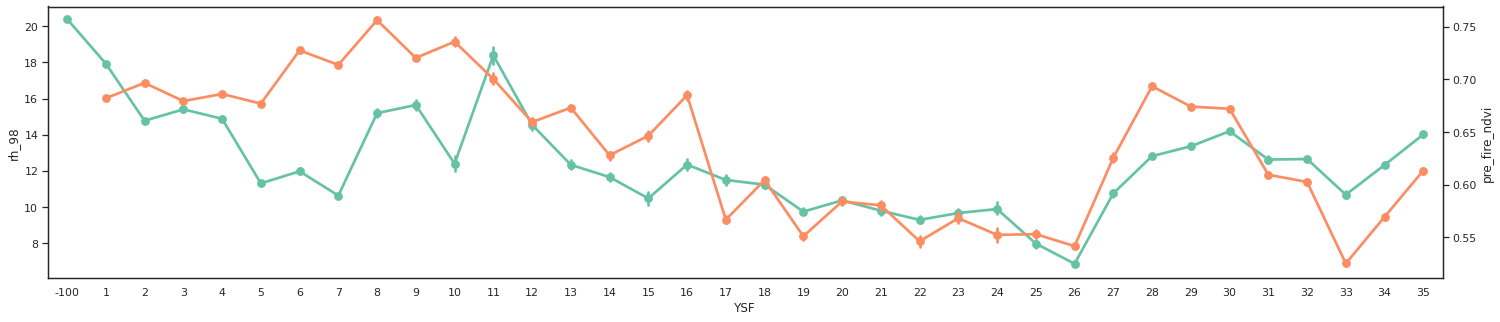

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
ax2 = ax.twinx()
sns.pointplot(df, x="YSF", y="rh_98", ax=ax, estimator="median")
sns.pointplot(df, x="YSF", y="pre_fire_ndvi", ax=ax2, color=palette[1], estimator="median")

<AxesSubplot: xlabel='YSF', ylabel='pre_fire_ndvi'>

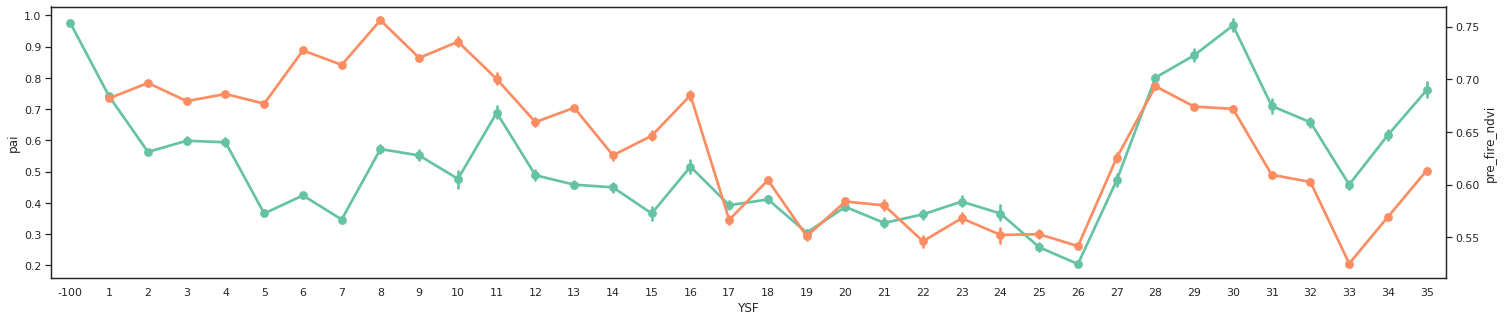

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
ax2 = ax.twinx()
sns.pointplot(df, x="YSF", y="pai", ax=ax, estimator="median")
sns.pointplot(df, x="YSF", y="pre_fire_ndvi", ax=ax2, color=palette[1], estimator="median")

Clearly the overall RH98 and PAI trends in SFT follow pre-fire ndvi values - so the trends we're seeing are at least partially just a consequence of sampling forests of different pre-fire NDVI values in space-for-time substitution. Clearly, forests that burned 20-25 years ago had lower pre-fire NDVI values than forests that burned 0-10 years ago. This is not ideal, as it indicates our data is not properly stratified.

## *Without controlling for pre-fire conditions, SFT will not work well - because the crucial condition is not fulfilled - the sites should be identical except for the time that past since the event being evaluated.*

<AxesSubplot: xlabel='YSF', ylabel='pre_fire_ndvi'>

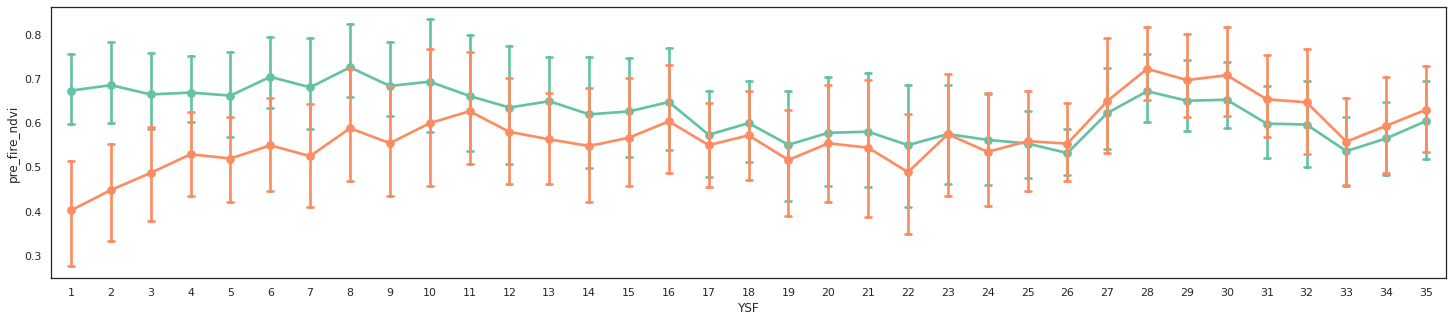

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned[burned.YSF >= 0], x="YSF", y="pre_fire_ndvi", ax=ax, errorbar=("pi", 50), capsize=.15)
sns.pointplot(burned[burned.YSF >= 0], x="YSF", y="ndvi", ax=ax, errorbar=("pi", 50), capsize=.15)

On the other hand, despite the problems with SFT sampling, NDVI shows us a clear pattern of recovery when doing SFT on NDVI. The gap is large, and then it narrows between pre-fire NDVI and post-fire NDVI.

This is likely because we are comparing apples to apples here - the same measurement for the same samples for each year. On the other hand, relationship between NDVI and gedi vars is non-linear and unclear, and the recovery may be much slower and different, so those two things could make us not see anything even if there was recovery going on.

We similar trends when we bucket YSF in 5 year increments - though the correspondence between pre-fire NDVI and GEDI is not exact, but it still does LOOK related.

<AxesSubplot: xlabel='YSF_cat_5', ylabel='pre_fire_ndvi'>

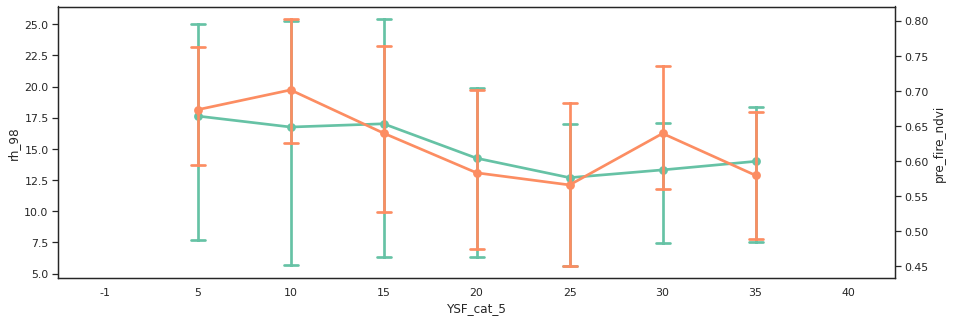

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax2 = ax.twinx()
sns.pointplot(df[df.YSF > 0], x="YSF_cat_5", y="rh_98", ax=ax, errorbar=("pi", 50), capsize=.15)
sns.pointplot(df[df.YSF > 0], x="YSF_cat_5", y="pre_fire_ndvi", ax=ax2, color=palette[1], errorbar=("pi", 50), capsize=.15)

<AxesSubplot: xlabel='YSF_cat_7', ylabel='pre_fire_ndvi'>

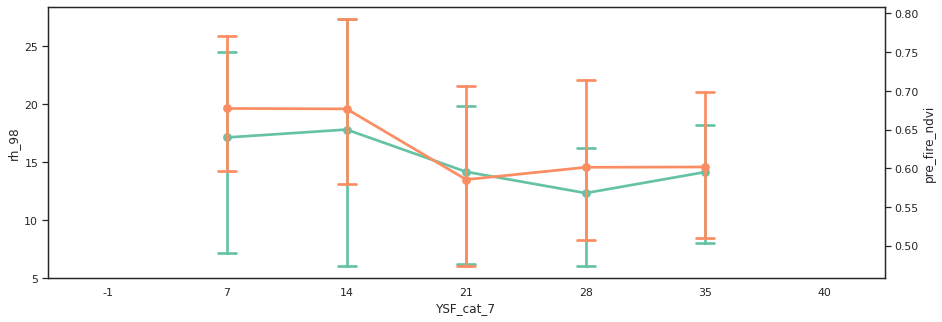

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax2 = ax.twinx()
sns.pointplot(df[df.YSF > 0], x="YSF_cat_7", y="rh_98", ax=ax, errorbar=("pi", 50), capsize=.15)
sns.pointplot(df[df.YSF > 0], x="YSF_cat_7", y="pre_fire_ndvi", ax=ax2, color=palette[1], errorbar=("pi", 50), capsize=.15)

Cover seems to indicate an increase in the last 5 year bucket.

<AxesSubplot: xlabel='YSF_cat_5', ylabel='pre_fire_ndvi'>

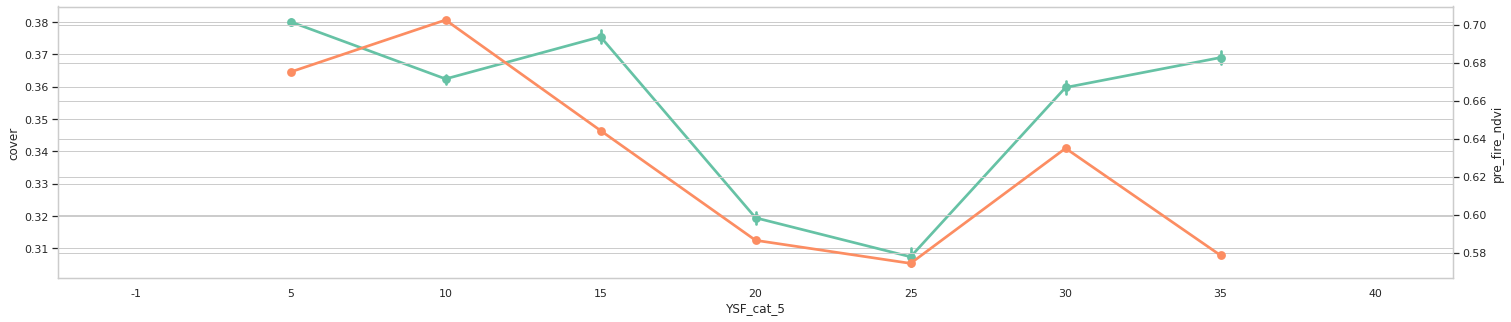

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
ax2 = ax.twinx()
sns.pointplot(df[df.YSF > 0], x="YSF_cat_5", y="cover", ax=ax)
sns.pointplot(df[df.YSF > 0], x="YSF_cat_5", y="pre_fire_ndvi", ax=ax2, color=palette[1])

The following plot shows what the terrain variables look like for each SFT bucket.

<AxesSubplot: xlabel='YSF_cat_5', ylabel='slope'>

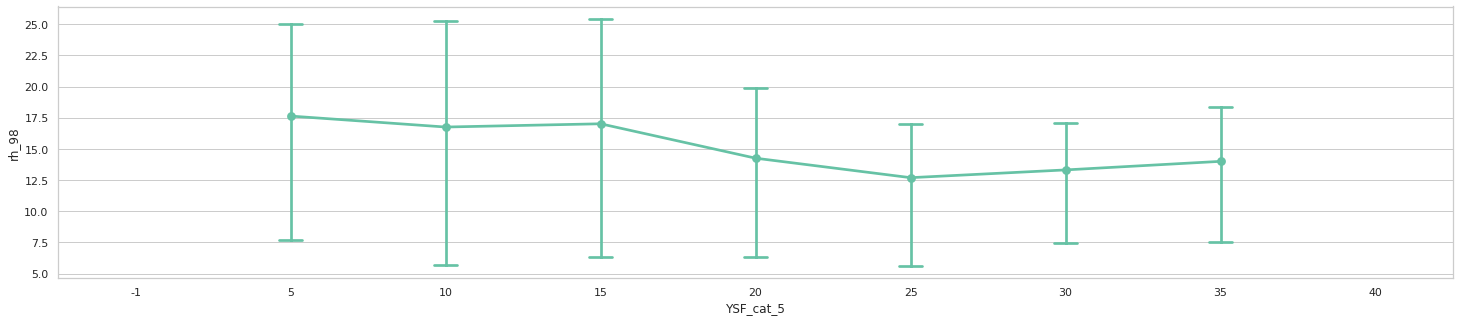

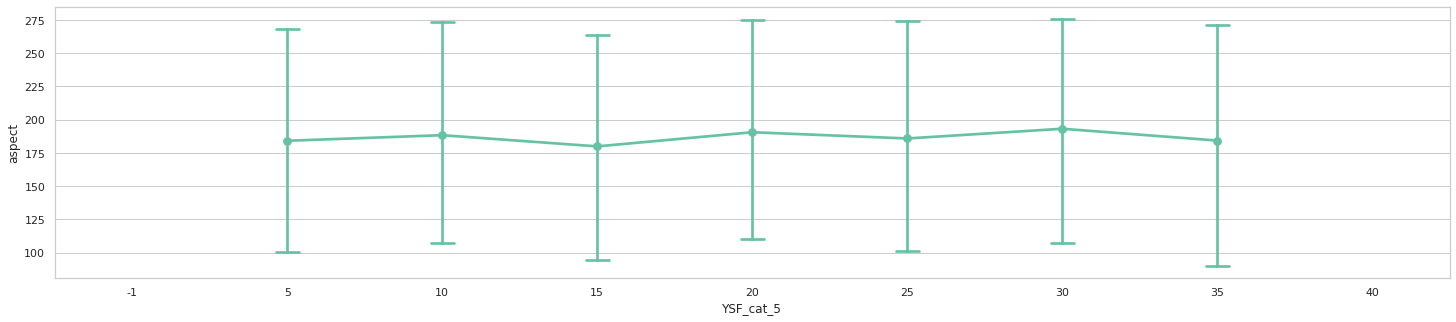

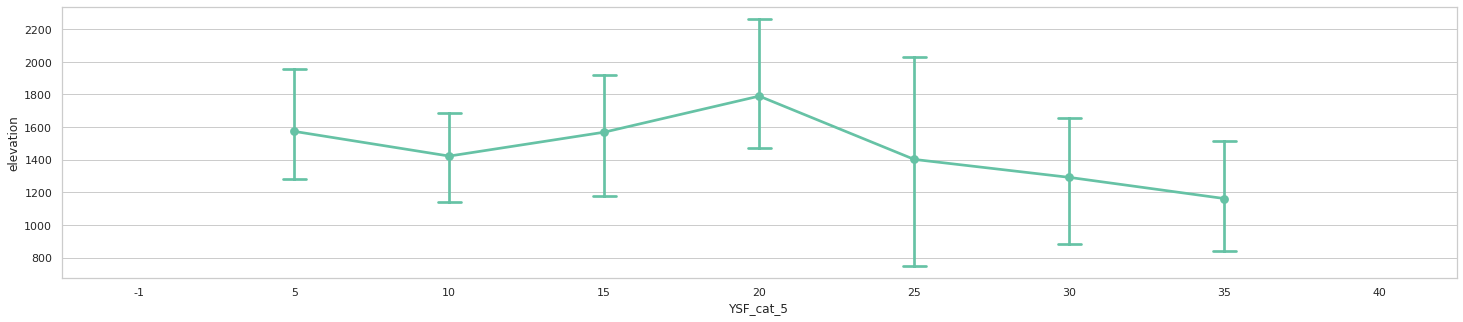

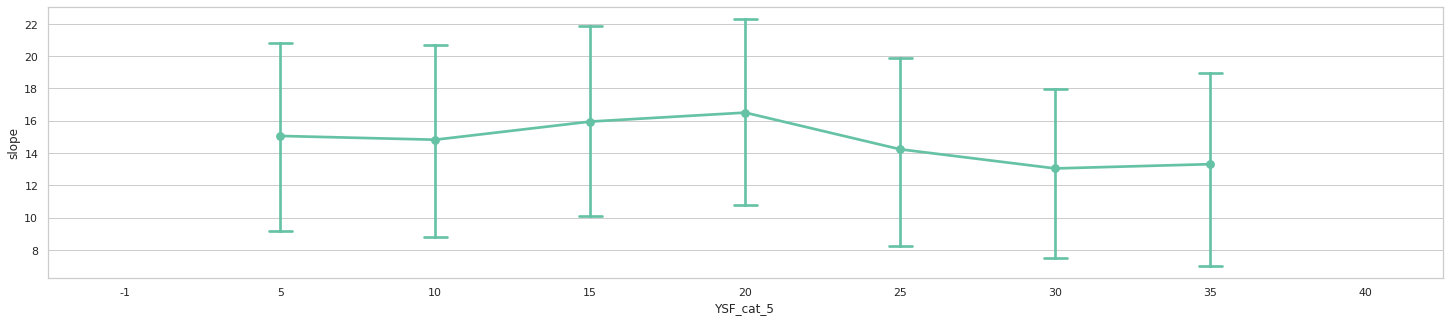

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="rh_98", errorbar=("pi", 50), capsize=.15)

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="aspect", errorbar=("pi", 50), capsize=.15)

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="elevation", errorbar=("pi", 50), capsize=.15)

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="slope", errorbar=("pi", 50), capsize=.15)


### Correlations

Let's calculate correlations between various variables, to further highlight potential relationships.

In [98]:
columns = [
 'fire_size_acres',
 'pre_fire_ndvi',
 'YSF',
 'YSF_cat_5',
 'agbd',
 'cover',
 'fhd_normal',
 'latitude',
 'longitude',
 'pai',
 'rh_25',
 'rh_50',
 'rh_70',
 'rh_98',
 'aspect',
 'elevation',
 'slope',
 'soil',
 'ndvi',
 'YSF_cat_7',
 'YSF_cat_10',
 'cover']

In [110]:
correlations_burned = burned[columns + ["ndvi_ratio"]].corr()
correlations_unburned = unburned[columns].corr()

In [111]:
correlations_burned.pre_fire_ndvi, correlations_unburned.pre_fire_ndvi

(fire_size_acres    0.107967
 pre_fire_ndvi      1.000000
 YSF               -0.252308
 YSF_cat_5         -0.250804
 agbd               0.323709
 cover              0.315472
 fhd_normal         0.287411
 latitude           0.160043
 longitude         -0.309755
 pai                0.274544
 rh_25              0.283254
 rh_50              0.343928
 rh_70              0.365417
 rh_98              0.348242
 aspect             0.036910
 elevation         -0.240278
 slope              0.158846
 soil              -0.213234
 ndvi               0.504268
 YSF_cat_7         -0.243312
 YSF_cat_10        -0.268276
 cover              0.315472
 ndvi_ratio        -0.207961
 Name: pre_fire_ndvi, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      1.000000
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.485285
 cover              0.495780
 fhd_normal         0.449959
 latitude           0.209385
 longitude         -0.450837
 pai                0.426531
 rh_2

In [112]:
correlations_burned.ndvi_ratio

fire_size_acres   -0.418229
pre_fire_ndvi     -0.207961
YSF                0.652190
YSF_cat_5          0.636664
agbd               0.107998
cover              0.128762
fhd_normal         0.148271
latitude           0.000740
longitude         -0.046623
pai                0.100654
rh_25              0.091037
rh_50              0.122542
rh_70              0.131934
rh_98              0.106668
aspect             0.029484
elevation         -0.159975
slope             -0.021141
soil               0.063745
ndvi               0.721920
YSF_cat_7          0.622033
YSF_cat_10         0.595802
cover              0.128762
ndvi_ratio         1.000000
Name: ndvi_ratio, dtype: float64

*Pre-fire NDVI ~ YSF = -0.25*
    
    Vegetation gets smaller as YSF increases, meaning that our samples from forests that burned longer time ago come from forests that have less vegetation. This will affect recovery trends negatively -> it might look like there is no recovery, even when there is.

*Pre-fire NDVI ~ AGBD (Unburned) > Pre-fire NDVI ~ AGBD (Burned)*
    
    Correlation between pre-fire NDVI with GEDI metrics is stronger for unburned regions, than burned -> presumably due to burned burning :D

*NDVI ratio ~ fire_size = -0.471  |  NDVI ratio ~ YSF = 0.64*
    
    NDVI ratio is negatively correlated with fire size, meaning the larger the fire, the worse the recovery. It's positively correlated with YSF which means as the years since fire increase, NDVI gets closer to its pre-fire values. We see similar but weaker trends for just looking at NDVI - -0.29 and 0.35 respectively. So, looking at the relative ratio shows much stronger recovery trends. Keep in mind that YSF itself is negatively correlated with fire_size - so the correlation betwen pre-fire NDVI and fire-size could be coming simply from the fact that our sampling of fire sizes is heterogeneous across SFT years.





In [113]:
correlations_burned.rh_70, correlations_unburned.rh_70

(fire_size_acres    0.013744
 pre_fire_ndvi      0.365417
 YSF               -0.083216
 YSF_cat_5         -0.079788
 agbd               0.933296
 cover              0.770074
 fhd_normal         0.623335
 latitude          -0.025895
 longitude         -0.050728
 pai                0.717368
 rh_25              0.750151
 rh_50              0.908878
 rh_70              1.000000
 rh_98              0.822415
 aspect             0.028372
 elevation         -0.082935
 slope              0.234400
 soil              -0.052765
 ndvi               0.380750
 YSF_cat_7         -0.068592
 YSF_cat_10        -0.075017
 cover              0.770074
 ndvi_ratio         0.131934
 Name: rh_70, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      0.550265
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.945308
 cover              0.784108
 fhd_normal         0.606483
 latitude           0.071141
 longitude         -0.203577
 pai                0.719698
 rh_25       

In [114]:
correlations_burned.pai, correlations_unburned.pai

(fire_size_acres   -0.010734
 pre_fire_ndvi      0.274544
 YSF               -0.018009
 YSF_cat_5         -0.016341
 agbd               0.577406
 cover              0.956338
 fhd_normal         0.478322
 latitude          -0.029998
 longitude         -0.053369
 pai                1.000000
 rh_25              0.924039
 rh_50              0.811744
 rh_70              0.717368
 rh_98              0.550437
 aspect             0.035665
 elevation         -0.147549
 slope              0.301219
 soil              -0.052902
 ndvi               0.285433
 YSF_cat_7         -0.008167
 YSF_cat_10        -0.011098
 cover              0.956338
 ndvi_ratio         0.100654
 Name: pai, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      0.426531
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.619544
 cover              0.950734
 fhd_normal         0.387365
 latitude           0.021248
 longitude         -0.154600
 pai                1.000000
 rh_25         

*RH 70 ~ terrain*
    
    RH 70 correlates with slope the most = 0.20 for unburned and 0.23 for burned regions, while correlation with elevation is negative and only about 0.1. No correlation with aspect.

*PAI ~ terrain*
    
    PAI has the strongest correlation with terrain of all GEDI metrics. Specifically it has 0.3 correlation with slope.

*GEDI ~ Pre-fire NDVI*
    
    All GEDI metrics are correlated with pre-fire NDVI, which means that heterogeneity of pre-fire NDVI will influence our SFT conclusions. Unburned regions are more highly correlated than burned regions. RH 70 is 0.55 for unburned, and 0.36 for burned.





In [116]:
correlations_burned.YSF, correlations_burned.YSF_cat_5

(fire_size_acres   -0.417896
 pre_fire_ndvi     -0.252308
 YSF                1.000000
 YSF_cat_5          0.991965
 agbd              -0.108031
 cover             -0.017579
 fhd_normal        -0.090177
 latitude           0.093984
 longitude         -0.127223
 pai               -0.018009
 rh_25             -0.036587
 rh_50             -0.054170
 rh_70             -0.083216
 rh_98             -0.143813
 aspect             0.014294
 elevation         -0.185890
 slope             -0.069053
 soil               0.106748
 ndvi               0.385730
 YSF_cat_7          0.980295
 YSF_cat_10         0.960866
 cover             -0.017579
 ndvi_ratio         0.652190
 Name: YSF, dtype: float64,
 fire_size_acres   -0.385938
 pre_fire_ndvi     -0.250804
 YSF                0.991965
 YSF_cat_5          1.000000
 agbd              -0.105176
 cover             -0.014763
 fhd_normal        -0.085744
 latitude           0.098749
 longitude         -0.128018
 pai               -0.016341
 rh_25         

In [118]:
correlations_unburned.elevation

fire_size_acres         NaN
pre_fire_ndvi     -0.320376
YSF                     NaN
YSF_cat_5               NaN
agbd              -0.064329
cover             -0.173854
fhd_normal         0.072551
latitude          -0.124436
longitude          0.497529
pai               -0.166942
rh_25             -0.192359
rh_50             -0.181462
rh_70             -0.118434
rh_98              0.008872
aspect             0.015035
elevation          1.000000
slope              0.124146
soil               0.105954
ndvi              -0.320376
YSF_cat_7               NaN
YSF_cat_10              NaN
cover             -0.173854
Name: elevation, dtype: float64

*YSF ~ other variables*
    
    YSF has a bit of a negative correlation with elevation - -0.17 which means that later recovery years are in lower elevations, which again in general would means higher vegetation - but we see the opposite trend, lower pre-fire NDVI with YSF. YSF has the largest correlation with fire_size, -0.41, which means that more recent fires are coming from larger fires, and the older fires are coming from smaller fires. Is this a general trend, or the consequence of data sampling? Yes - a general trend, see below.



In [119]:
all_fires = mtbs_adapter.get_mtbs_perimeters_for_sierras()

In [121]:
all_fires["fire_year"] = all_fires.fire_ig_date.dt.year

In [149]:
cum_size = all_fires.groupby(["fire_year"]).fire_size_acres.sum()

<AxesSubplot: xlabel='fire_year', ylabel='fire_size_acres'>

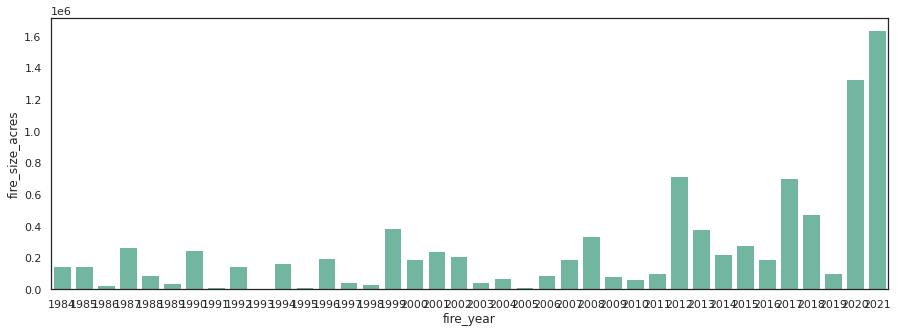

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot(cum_size)

<AxesSubplot: xlabel='fire_year', ylabel='fire_size_acres'>

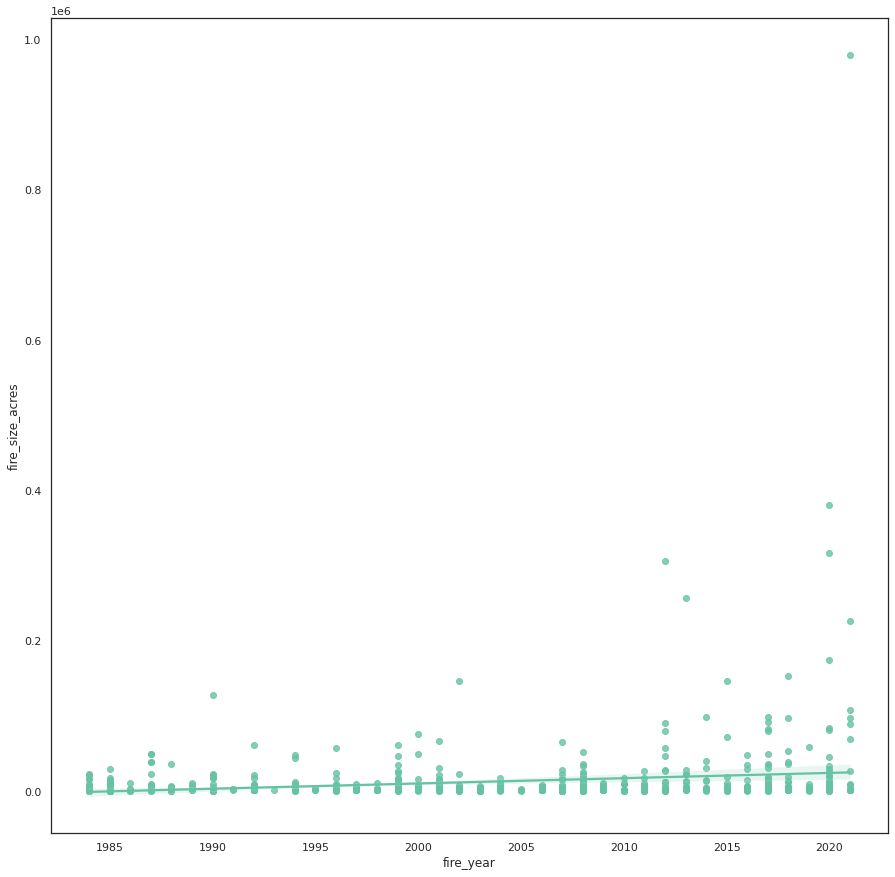

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.regplot(all_fires, x="fire_year", y="fire_size_acres", scatter=True)

Total area burned is larger in larger fires (d'oh) and in more recent years, fires were larger - so we're going to have a bunch of samples from small YSF coming from large fires, which means we do expect fire size to be negatively correlated with YSF. 

### Plot correlations

<AxesSubplot: xlabel='slope', ylabel='rh_70'>

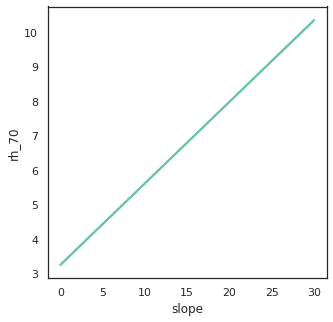

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(burned, x="slope", y="rh_70", scatter=False)

<AxesSubplot: xlabel='YSF', ylabel='rh_70'>

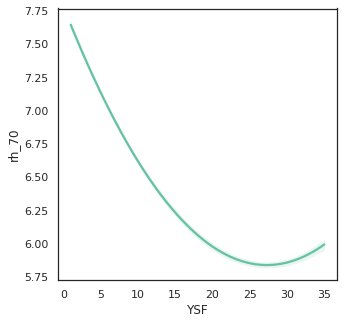

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(burned, x="YSF", y="rh_70", scatter=False, order=2)

<AxesSubplot: xlabel='YSF'>

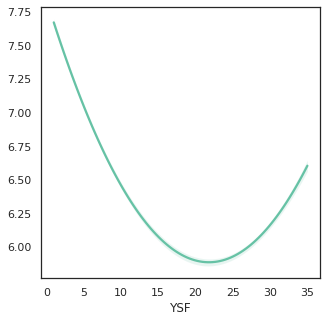

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(burned, x="YSF", y="rh_70", scatter=False, y_partial="slope", order=2)

<AxesSubplot: xlabel='YSF'>

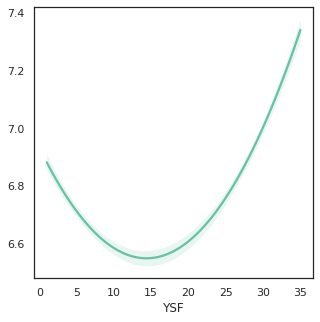

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(burned, x="YSF", y="rh_70", scatter=False, y_partial="pre_fire_ndvi", order=2)

We observe that RH 70 mostly decreases with YSF, but that the shape of the trend changes once we account for slope and pre-fire NDVI to a more upward trajectory.

### Modeling

In [186]:
dfp = burned[["slope", "pre_fire_ndvi", "ndvi", "YSF", "elevation", "dnbr_mean", "fire_size_acres", "latitude", "longitude", "rh_70"]].dropna()

In [187]:
x = dfp.slope.to_numpy()
a = dfp.pre_fire_ndvi.to_numpy()
b = dfp.YSF.to_numpy()
c = dfp.elevation.to_numpy()
d = dfp.dnbr_mean.to_numpy()
e = dfp.fire_size_acres.to_numpy()
f= dfp.latitude.to_numpy()
g = dfp.longitude.to_numpy()

### Model NDVI

With just pre-fire NDVI values and YSF, we achieve R^2 of more than 0.5.

In [183]:
y = dfp.ndvi.to_numpy()
X = sm.add_constant(np.stack([a,  b]).T)

In [184]:
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                 4.819e+05
Date:                Tue, 23 Jan 2024   Prob (F-statistic):               0.00
Time:                        01:10:01   Log-Likelihood:             6.2063e+05
No. Observations:              836626   AIC:                        -1.241e+06
Df Residuals:                  836623   BIC:                        -1.241e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0932      0.001   -134.886      0.0

### Model RH70

Including just pre-fire values like pre-fire NDVI, slope and YSF, R^2 is pretty crappy.

In [192]:
y = dfp.rh_70.to_numpy()
X = sm.add_constant(np.stack([x, a,  b**2]).T)

In [193]:
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                 5.551e+04
Date:                Tue, 23 Jan 2024   Prob (F-statistic):               0.00
Time:                        01:12:10   Log-Likelihood:            -2.7947e+06
No. Observations:              836626   AIC:                         5.589e+06
Df Residuals:                  836622   BIC:                         5.590e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.4525      0.041   -207.430      0.0

### Density plots of various variables

In [212]:
def plot_density(df, metric):
    fig, ax = plt.subplots(1, 1, figsize=(25, 15))
    sns.kdeplot(df[df.YSF_cat_5 == -1], x=metric, ax=ax, color="red")
    sns.kdeplot(df[df.YSF_cat_5 == 5], x=metric, ax=ax, color="green")
    sns.kdeplot(df[df.YSF_cat_5 == 15], x=metric, ax=ax, color="blue")
    sns.kdeplot(df[df.YSF_cat_5 == 20], x=metric, ax=ax, color="purple")
    sns.kdeplot(df[df.YSF_cat_5 == 25], x=metric, ax=ax, color="pink")
    sns.kdeplot(df[df.YSF_cat_5 == 30], x=metric, ax=ax, color="yellow")
    sns.kdeplot(df[df.YSF_cat_5 == 35], x=metric, ax=ax, color="black")
    return fig, ax

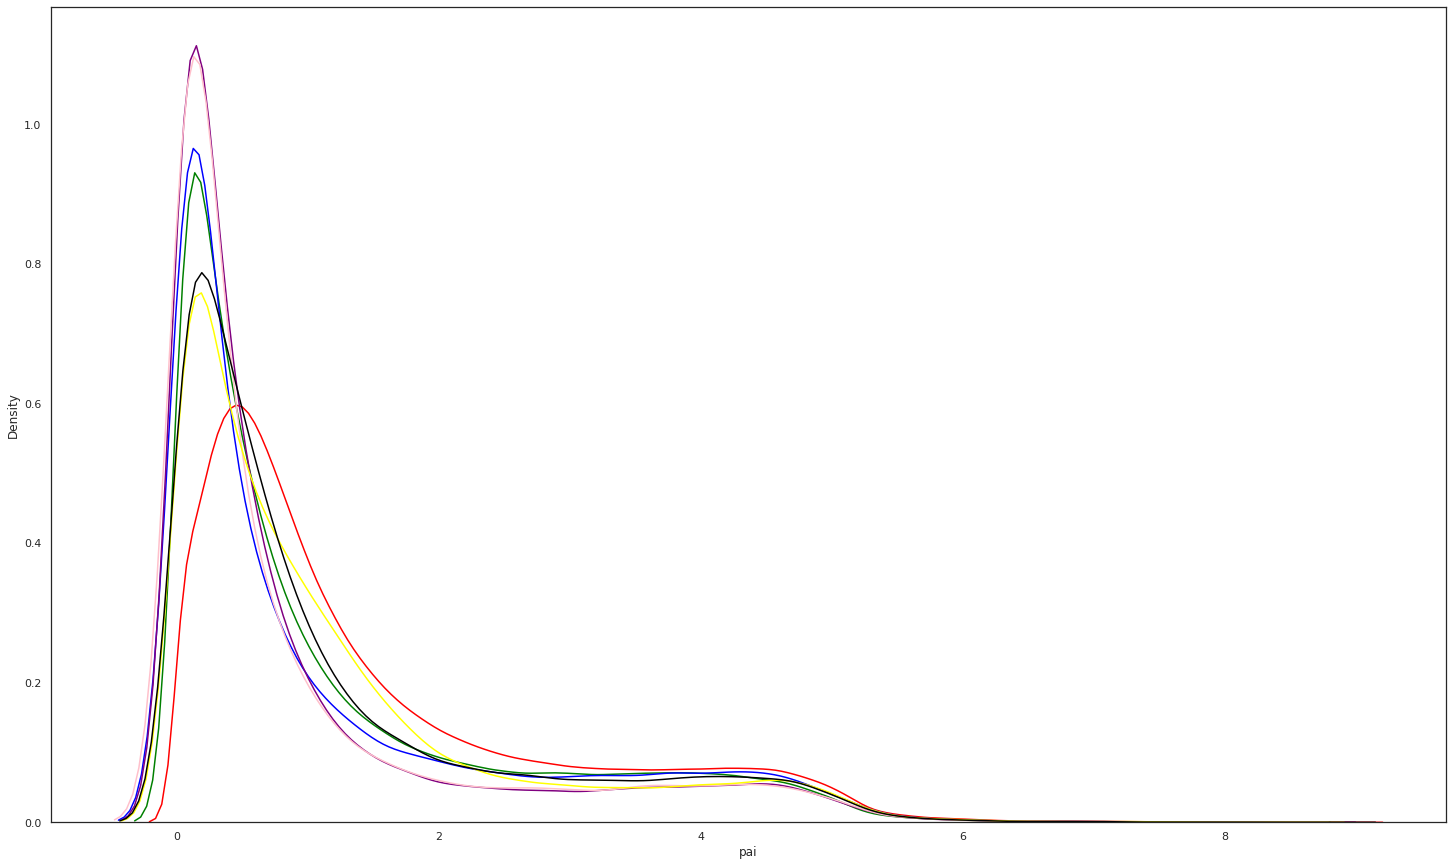

In [213]:
fig, ax = plot_density(df, "pai")

(0.0, 70.0)

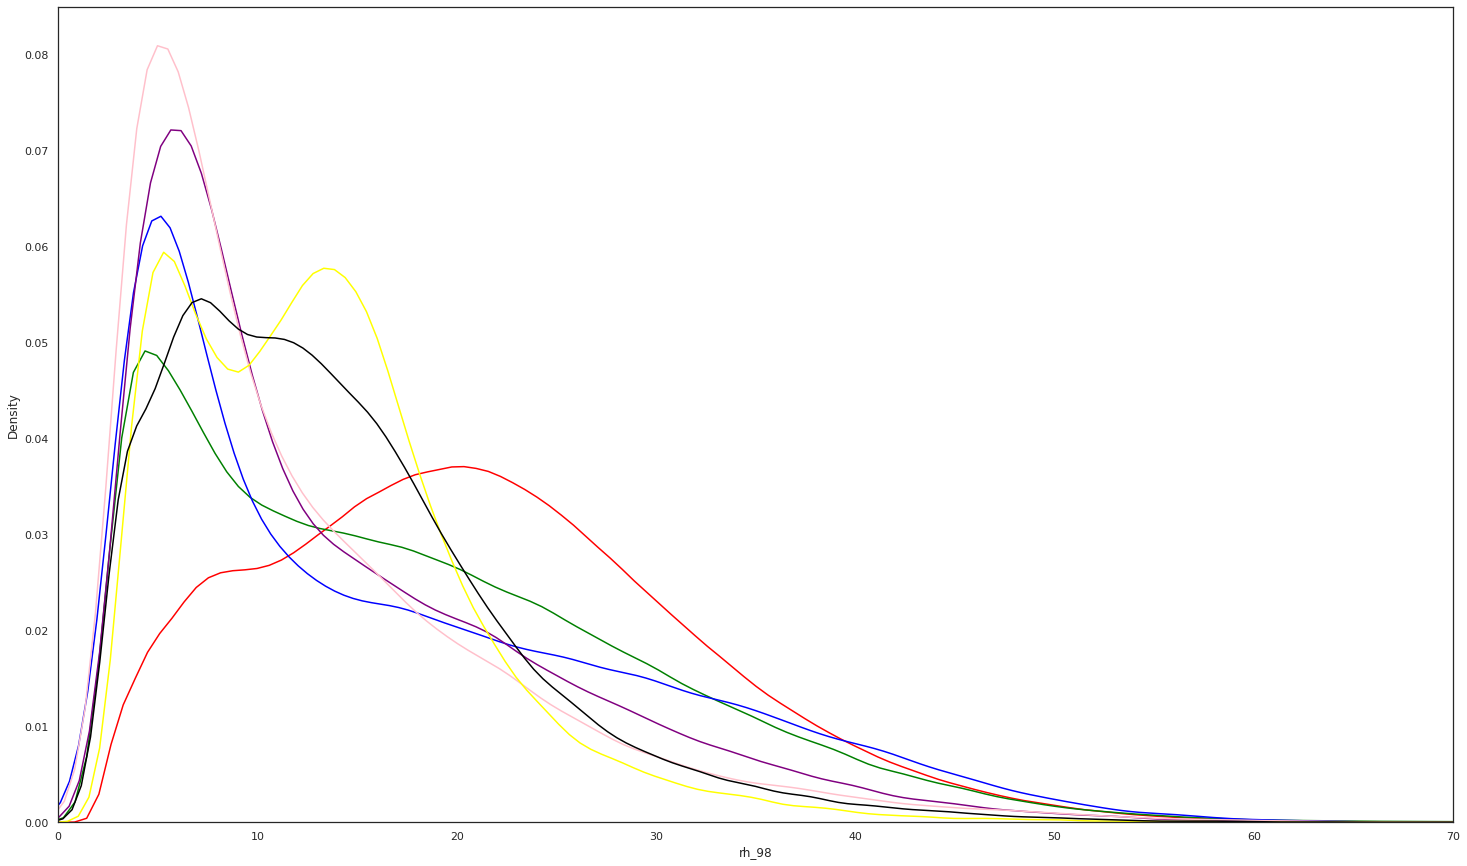

In [198]:
fig, ax = plot_density(df, "rh_98")
ax.set_xlim((0, 70))

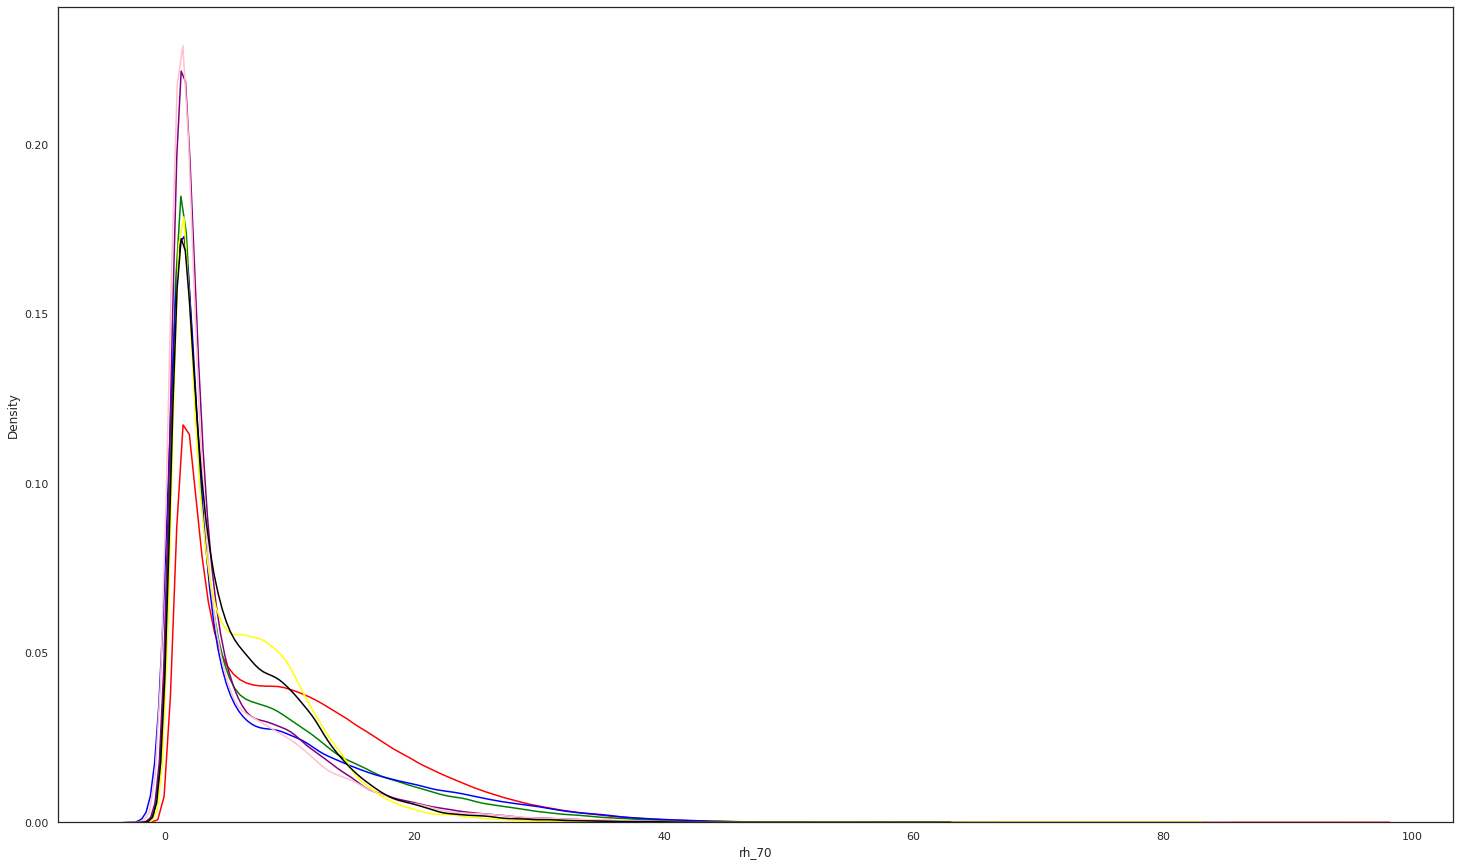

In [214]:
fig, ax = plot_density(df, "rh_70")

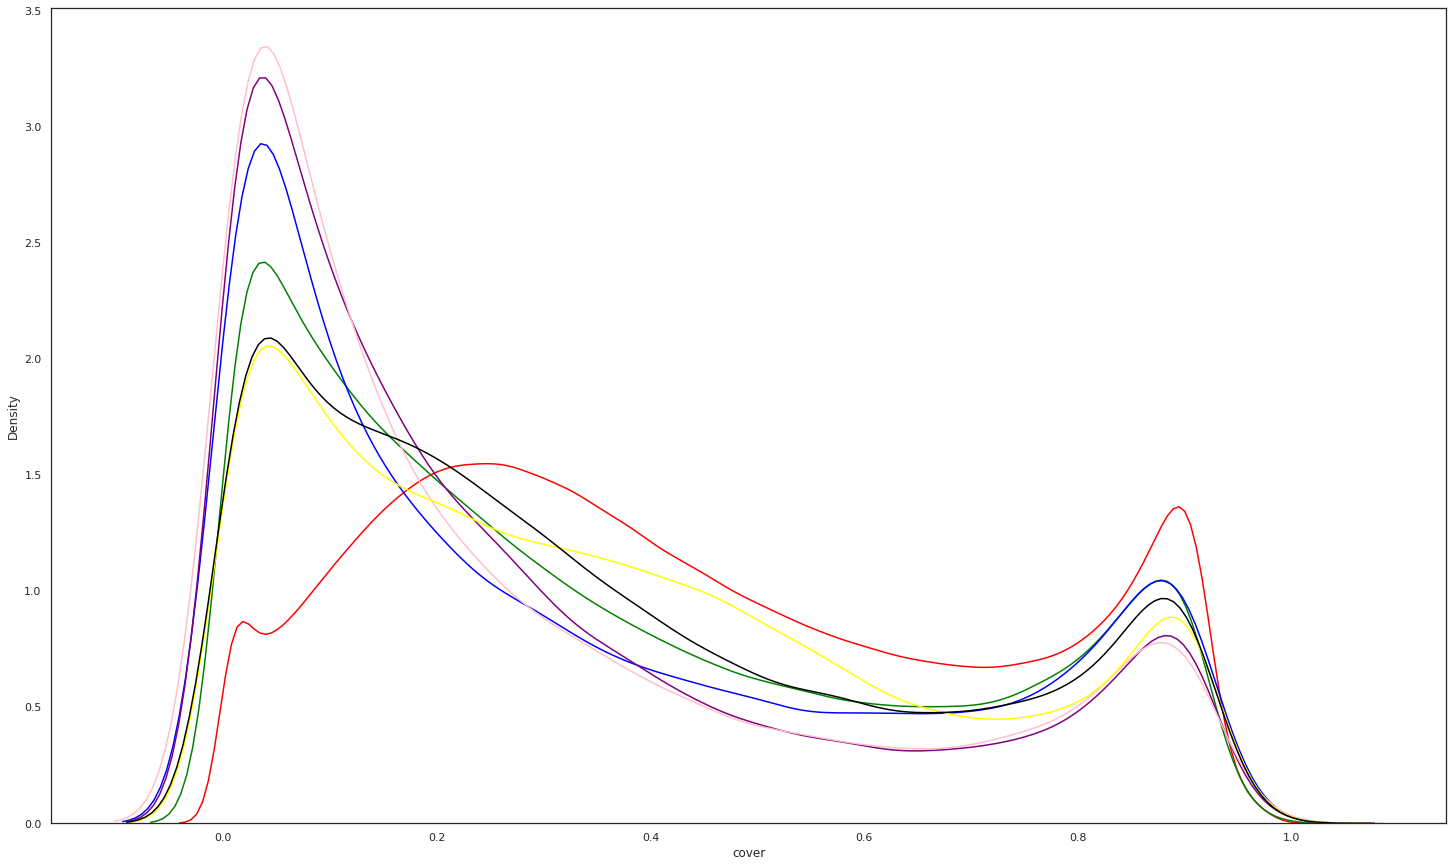

In [215]:
fig, ax = plot_density(df, "cover")

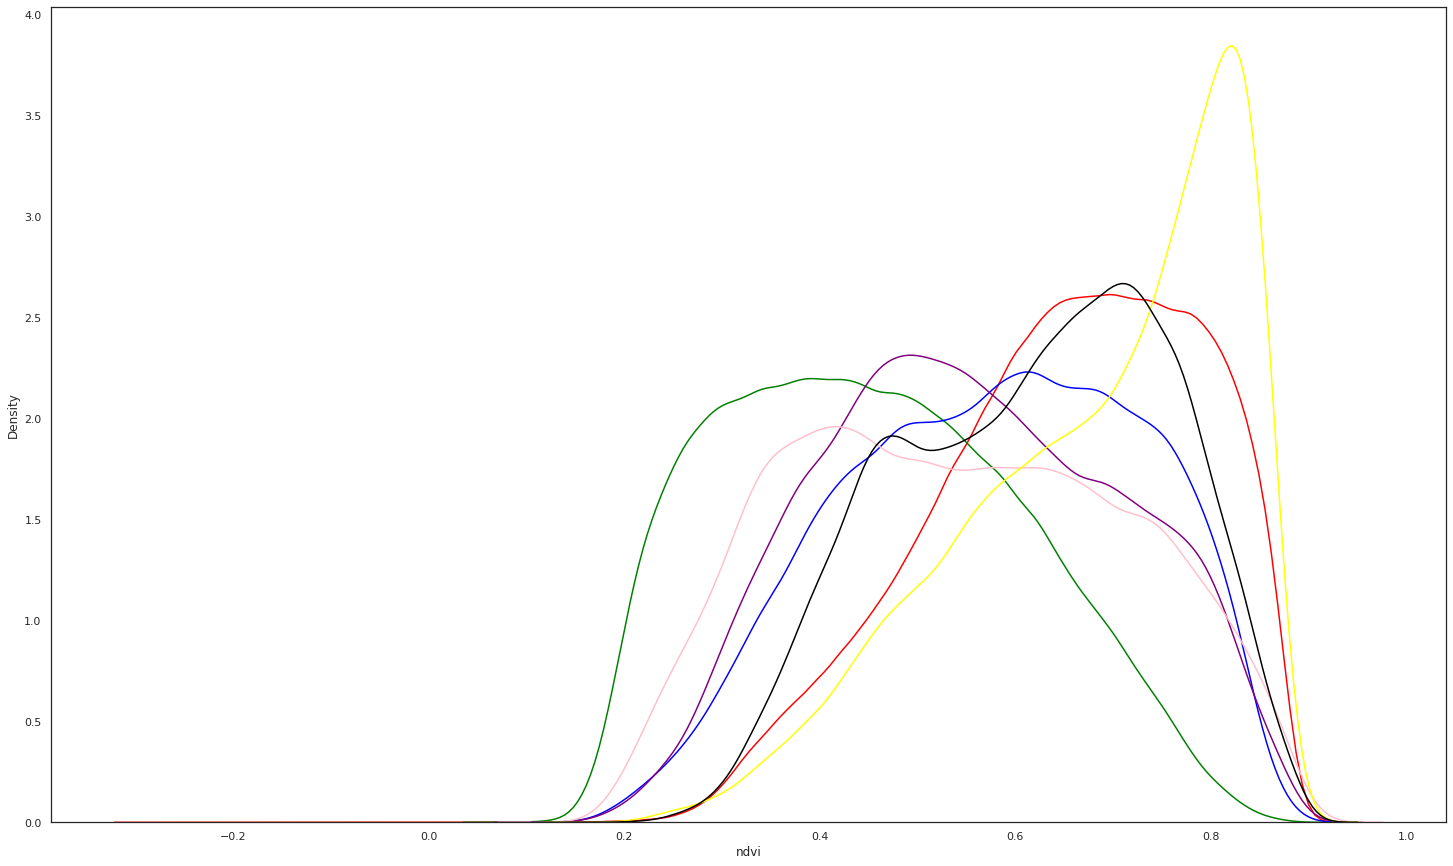

In [216]:
fig, ax = plot_density(df, "ndvi")

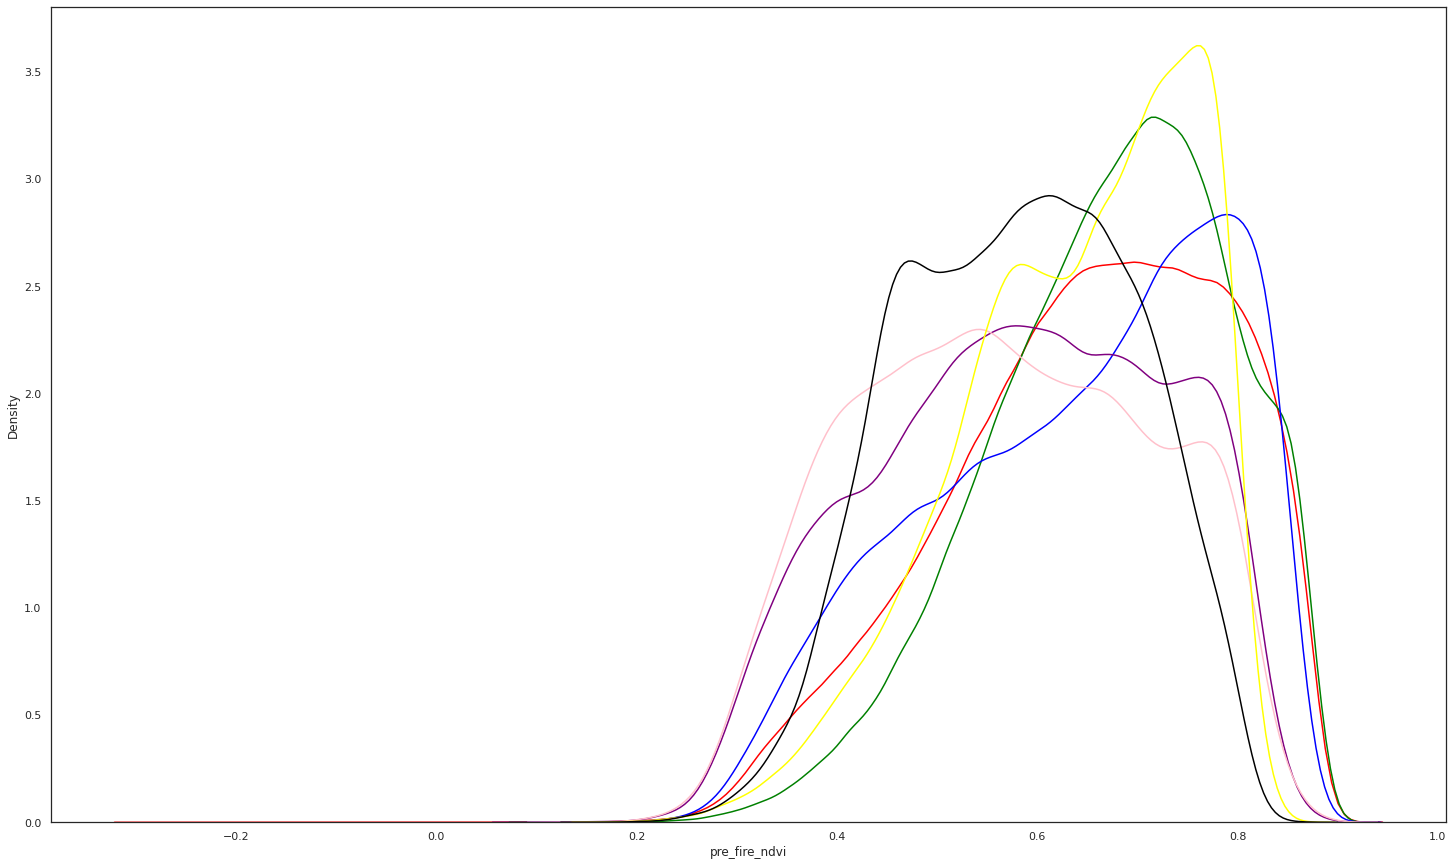

In [217]:
fig, ax = plot_density(df, "pre_fire_ndvi")

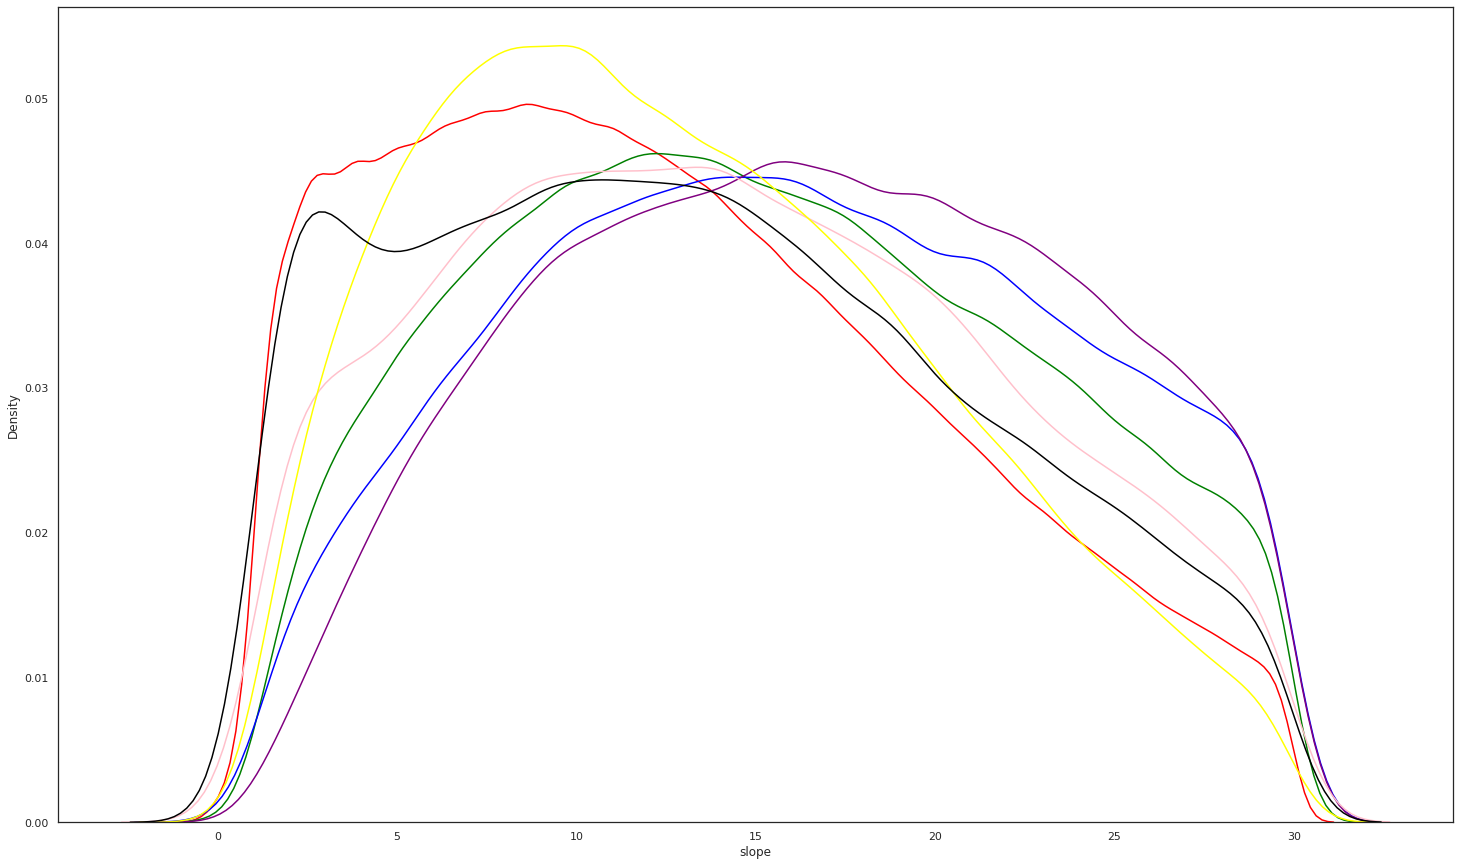

In [218]:
fig, ax = plot_density(df, "slope")

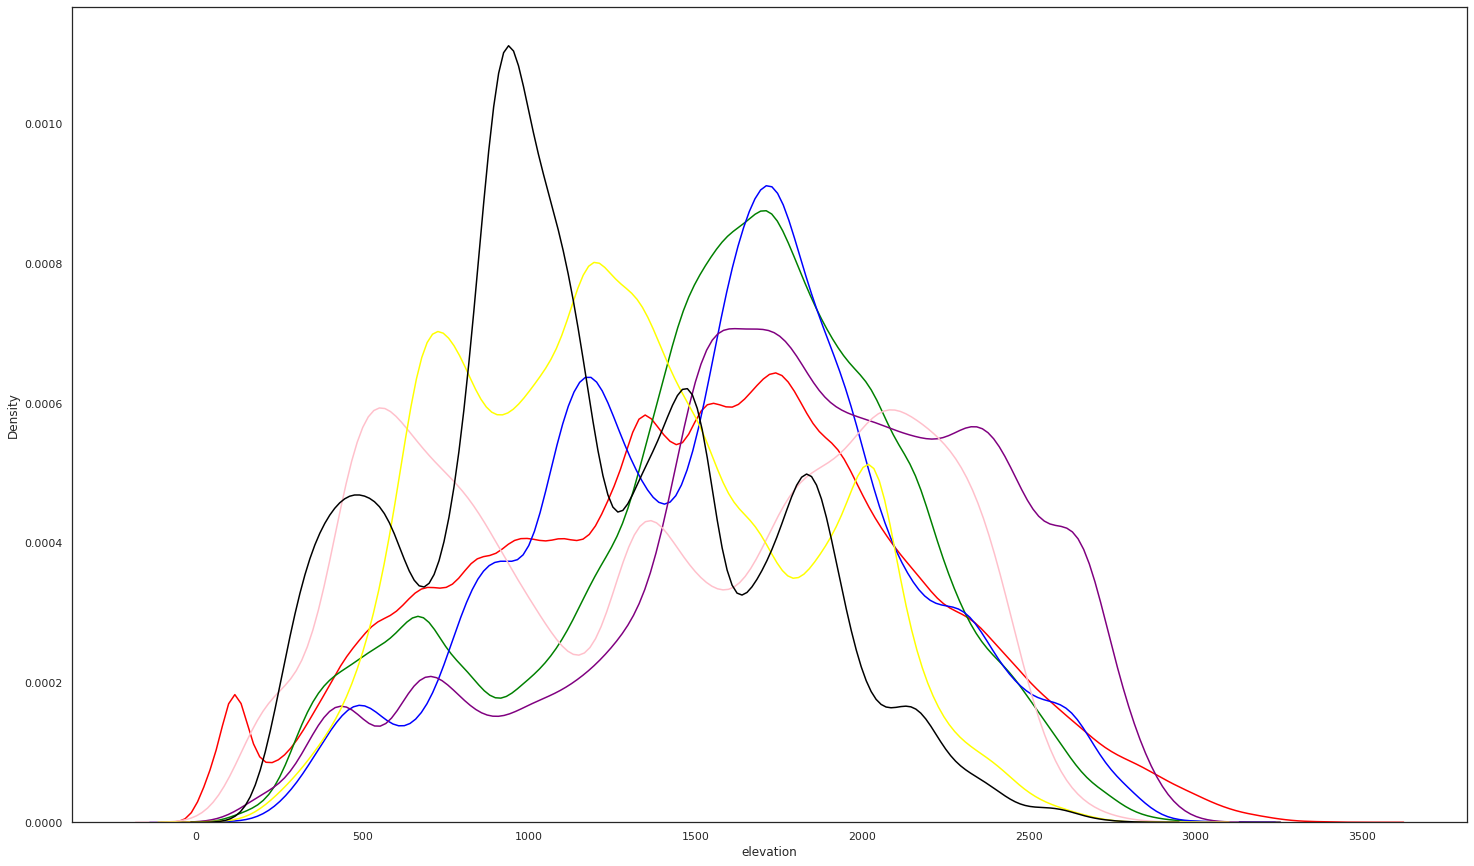

In [219]:
fig, ax = plot_density(df, "elevation")